# 1. Сюда просто скопирован код симулятора от генотека

In [14]:
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import bernoulli

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [16]:
EPS = 1e-10
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [17]:
def generate_matrices(population_sizes, p, teta=5, offset = 3.0):
    pop_index = []
    n_pops = len(population_sizes)
    for i in range(n_pops):
        pop_index += [i]*population_sizes[i]

    pop_index = np.array(pop_index)
    print(f"{n_pops=}")
    blocks_sums = [[np.zeros(shape=(population_sizes[i], population_sizes[j])) for i in range(n_pops)] for j in range(n_pops)]
    blocks_counts = [[np.zeros(shape=(population_sizes[i], population_sizes[j])) for i in range(n_pops)] for j in range(n_pops)]

    for pop_i in range(n_pops):
        for pop_j in range(pop_i+1):
            print(f"{pop_i=} {pop_j=}")
            pop_cross = population_sizes[pop_i] * population_sizes[pop_j]
            bern_samples = bernoulli.rvs(p[pop_i,pop_j], size = pop_cross)
            total_segments = np.sum(bern_samples)
            print(f"{total_segments=}")
            exponential_samples = np.random.exponential(teta, size=total_segments) + offset
            position = 0
            exponential_totals_samples = np.zeros(pop_cross, dtype=np.float64)
            mean_totals_samples = np.zeros(pop_cross, dtype=np.float64)
            exponential_totals_samples[bern_samples==1] = exponential_samples

            bern_samples = np.reshape(bern_samples, newshape=(population_sizes[pop_i], population_sizes[pop_j]))
            exponential_totals_samples=np.reshape(exponential_totals_samples, newshape=(population_sizes[pop_i], population_sizes[pop_j]))
            if(pop_i==pop_j):
                bern_samples = np.tril(bern_samples,-1)
                exponential_totals_samples = np.tril(exponential_totals_samples,-1)
            blocks_counts[pop_i][pop_j] = bern_samples
            blocks_sums[pop_i][pop_j] = exponential_totals_samples
    return np.nan_to_num(symmetrize(np.block(blocks_counts))), np.nan_to_num(symmetrize(np.block(blocks_sums))), pop_index


def generate_graph(means, counts, pop_index):
    indiv = list(range(counts.shape[0]))
    #print(indiv)
    G = nx.Graph()
    structr = [ (indiv[i],{"means": np.concatenate((means[i],counts[i])), "y": pop_index[i]}) for i in range(len(pop_index))]
    #print(structr)
    G.add_nodes_from(structr)
    for i in range(counts.shape[0]):
        for j in range(i):
            if(means[i][j]):
                G.add_edge(i, j, len = 1/(counts[i][j] + EPS), weight = counts[i][j])

    # remove isolated nodes
    #G.remove_nodes_from(list(nx.isolates(G)))
    return G

In [18]:
### code for modelling
#N = 75
N = 1000
population_sizes = [N,N,N, N, N]
#p = np.array([[0.5,0.45,0.45],[0.45,0.5,0.45], [0.45,0.45,0.5]])
p = np.array([[0.11097308, 0.0012959 , 0.00127431, 0.00258547, 0.00579579],
       [0.0012959 , 0.01644648, 0.00550097, 0.00708765, 0.00633572],
       [0.00127431, 0.00550097, 0.01359845, 0.00528573, 0.00422982],
       [0.00258547, 0.00708765, 0.00528573, 0.01403417, 0.00744347],
       [0.00579579, 0.00633572, 0.00422982, 0.00744347, 0.01977209]])

means, counts, pop_index = generate_matrices(population_sizes, p)
G = generate_graph(means, counts, pop_index)
print(G)
#print(G.edges)

n_pops=5
pop_i=0 pop_j=0
total_segments=110817
pop_i=1 pop_j=0
total_segments=1293
pop_i=1 pop_j=1
total_segments=16593
pop_i=2 pop_j=0
total_segments=1231
pop_i=2 pop_j=1
total_segments=5352
pop_i=2 pop_j=2
total_segments=13585
pop_i=3 pop_j=0
total_segments=2622
pop_i=3 pop_j=1
total_segments=7127
pop_i=3 pop_j=2
total_segments=5370
pop_i=3 pop_j=3
total_segments=14178
pop_i=4 pop_j=0
total_segments=5809
pop_i=4 pop_j=1
total_segments=6313
pop_i=4 pop_j=2
total_segments=4159
pop_i=4 pop_j=3
total_segments=7463
pop_i=4 pop_j=4
total_segments=19572
Graph with 5000 nodes and 134182 edges


# 2. Рассчитаем фичи сгенерированных вершин

In [19]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import ibdloader
import baseheuristic as bh

datapath = "../datasets-genotek/"

#pairs_1, weights, labels, labeldict
labels = np.array(pop_index)
labeldict = {"pop"+str(idx):idx for idx in range(len(population_sizes))}
print (labels)
print(labeldict)

[0 0 0 ... 4 4 4]
{'pop0': 0, 'pop1': 1, 'pop2': 2, 'pop3': 3, 'pop4': 4}


In [20]:
pairs = []
weights = []
for ed in G.edges:
    a, b = ed
    d = G.get_edge_data(a,b)
    pairs.append([a,b,1])
    weights.append([d['weight']])
    

pairs = np.array(pairs)
weights = np.array(weights)
print(weights)

#соберем полный граф
G = nx.Graph()
for idx, edge in enumerate(pairs):
    G.add_edge(edge[0], edge[1], weight=weights[idx])

print(G)
#сгруппируем вершины по классам

nodeclasses = {}
for label in labeldict:
    idx = labeldict[label]
    nodeclasses[label] = np.argwhere(labels==idx).flatten()


    
print("Размер каждого класса")
for label in nodeclasses:
    print (f"{label}: {nodeclasses[label].shape[0]}")

print(len(G.nodes))

[[ 4.26008386]
 [11.20711786]
 [ 6.09590662]
 ...
 [11.66764967]
 [27.29683212]
 [ 3.65813383]]
Graph with 5000 nodes and 134182 edges
Размер каждого класса
pop0: 1000
pop1: 1000
pop2: 1000
pop3: 1000
pop4: 1000
5000


Distribution of ibd sum
Total values: 134182 min: [3.00000359] max: [56.6545799] ave: 8.016381416529752
filtered values: 134173 min: 3.0000035851680042 max: 49.68861104445384 ave: 8.01342346804211


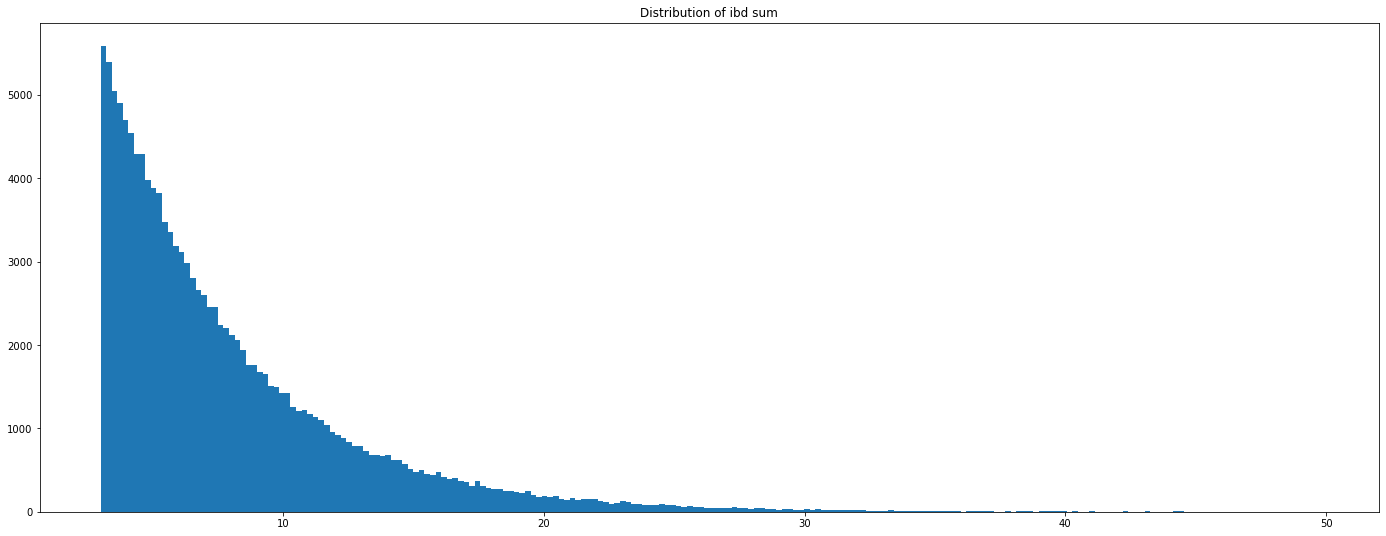

Distribution of ibd count
Total values: 134182 min: 1 max: 1 ave: 1.0
filtered values: 134182 min: 1 max: 1 ave: 1.0


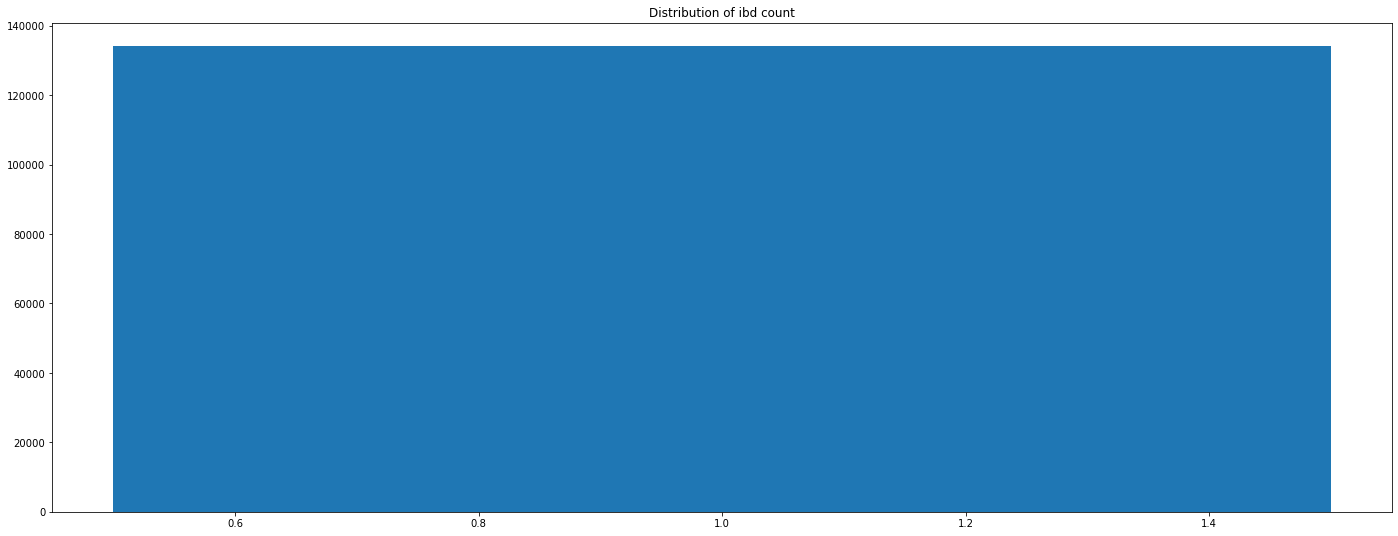

In [21]:
bh.plot_distribution(weights, 50, "Distribution of ibd sum")
bh.plot_distribution(pairs[:,2], 100, "Distribution of ibd count")

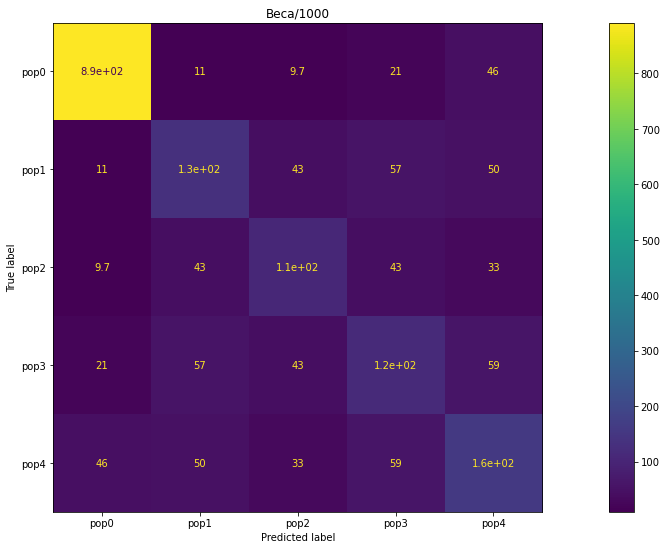

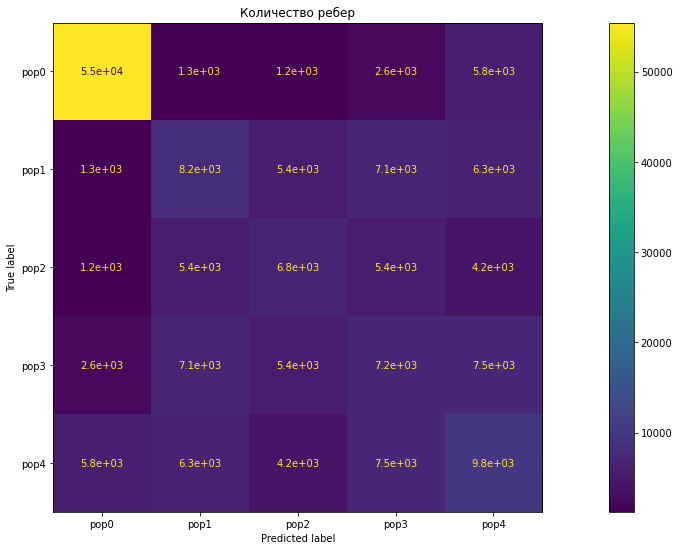

In [22]:
weimatrix, countmatrix = bh.getweightandcountmatrices(G, nodeclasses, labeldict, plot_distr=False)
# в тысячах
cm_display = ConfusionMatrixDisplay(weimatrix/1000, display_labels=labeldict.keys()).plot()
cm_display.ax_.set_title("Веса/1000")
plt.show()
cm_display = ConfusionMatrixDisplay(countmatrix, display_labels=labeldict.keys()).plot()
cm_display.ax_.set_title("Количество ребер")
plt.show()


# Классификация

Построим матрицы ошибок по:

1. количеству ребер до известных классов
2. числу ребер на количество членов класса
3. количеству ibd-сегментов до известных классов
4. самому длинный сегмент
5. весу на ребро
6. суммарному весу ребер до известных классов



features collected in 137.9772391319275 seconds

Число ребер до класса: Accuracy: 0.9588, correct: 4794, total: 5000
              precision    recall  f1-score   support

        pop0       1.00      1.00      1.00      1000
        pop1       0.92      0.97      0.94      1000
        pop2       0.98      0.95      0.96      1000
        pop3       0.96      0.89      0.92      1000
        pop4       0.95      0.98      0.97      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



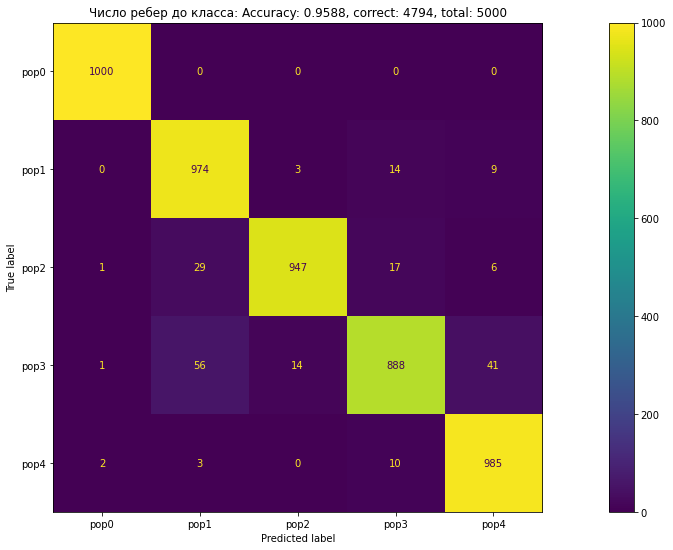

Число ребер до класса на размер класса: Accuracy: 0.9588, correct: 4794, total: 5000
              precision    recall  f1-score   support

        pop0       1.00      1.00      1.00      1000
        pop1       0.92      0.97      0.94      1000
        pop2       0.98      0.95      0.96      1000
        pop3       0.96      0.89      0.92      1000
        pop4       0.95      0.98      0.97      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



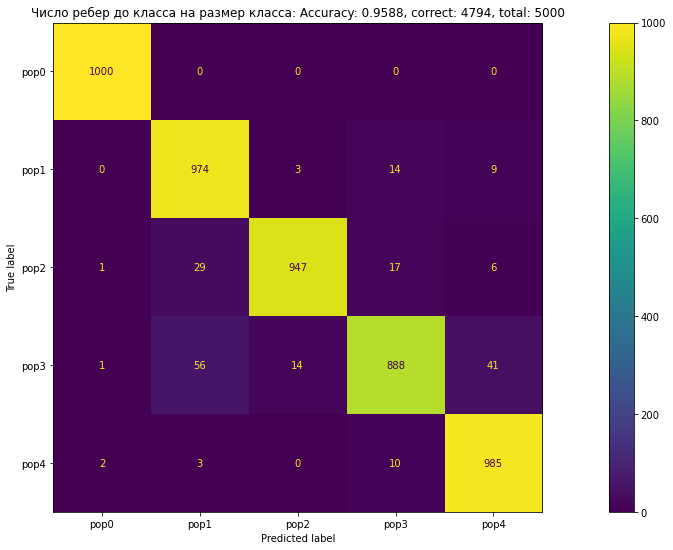

Число ребер до класса с учетом сегментов: Accuracy: 0.9588, correct: 4794, total: 5000
              precision    recall  f1-score   support

        pop0       1.00      1.00      1.00      1000
        pop1       0.92      0.97      0.94      1000
        pop2       0.98      0.95      0.96      1000
        pop3       0.96      0.89      0.92      1000
        pop4       0.95      0.98      0.97      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



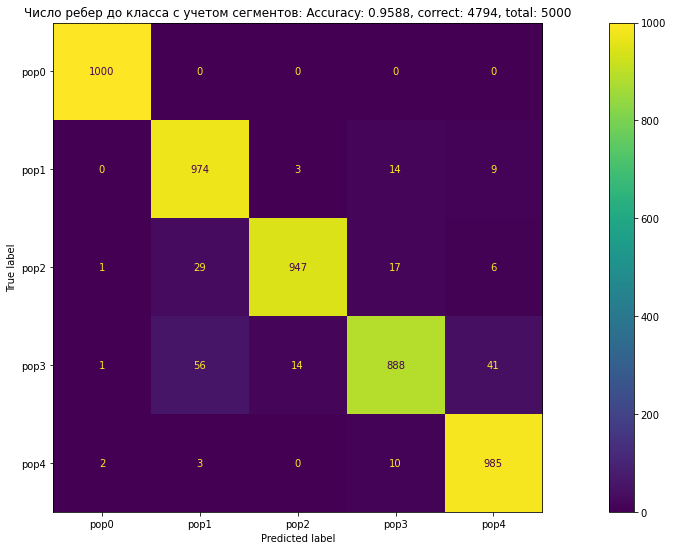

Самый длинный сегмент: Accuracy: 0.5234, correct: 2617, total: 5000
              precision    recall  f1-score   support

        pop0       0.76      0.91      0.83      1000
        pop1       0.42      0.41      0.41      1000
        pop2       0.54      0.45      0.49      1000
        pop3       0.41      0.41      0.41      1000
        pop4       0.44      0.44      0.44      1000

    accuracy                           0.52      5000
   macro avg       0.51      0.52      0.52      5000
weighted avg       0.51      0.52      0.52      5000



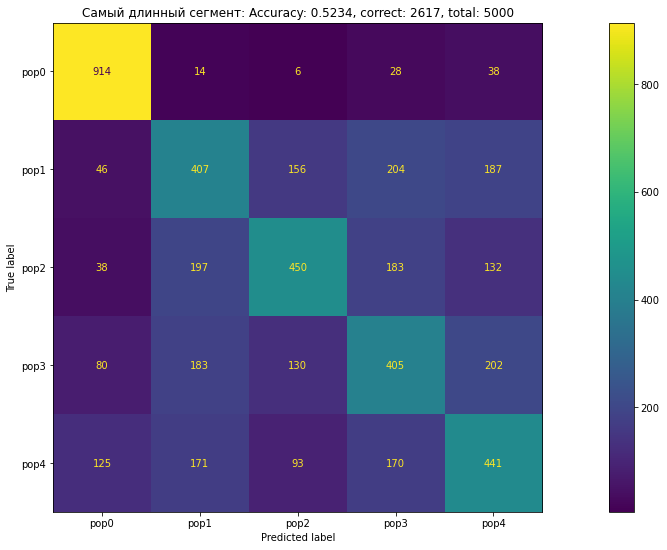

Сумма IBD до класса: Accuracy: 0.9242, correct: 4621, total: 5000
              precision    recall  f1-score   support

        pop0       0.99      1.00      1.00      1000
        pop1       0.89      0.92      0.90      1000
        pop2       0.96      0.90      0.93      1000
        pop3       0.89      0.83      0.86      1000
        pop4       0.89      0.97      0.93      1000

    accuracy                           0.92      5000
   macro avg       0.93      0.92      0.92      5000
weighted avg       0.93      0.92      0.92      5000



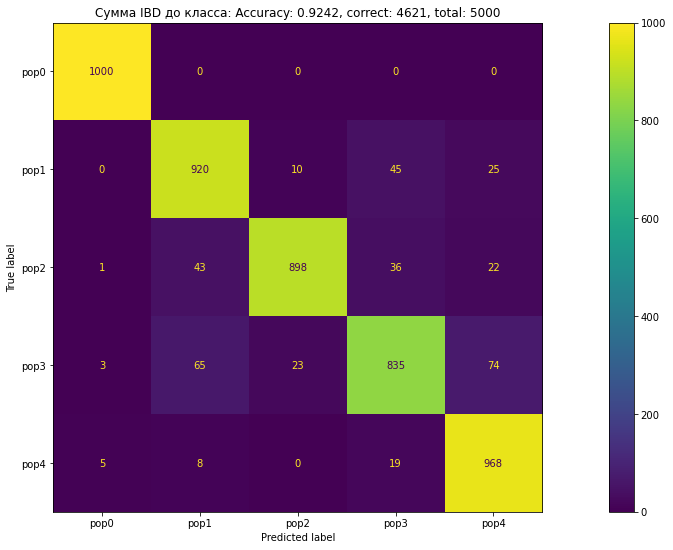

Сумма IBD до класса на ребро: Accuracy: 0.1708, correct: 854, total: 5000
              precision    recall  f1-score   support

        pop0       0.19      0.19      0.19      1000
        pop1       0.18      0.18      0.18      1000
        pop2       0.17      0.16      0.16      1000
        pop3       0.16      0.16      0.16      1000
        pop4       0.17      0.17      0.17      1000

    accuracy                           0.17      5000
   macro avg       0.17      0.17      0.17      5000
weighted avg       0.17      0.17      0.17      5000



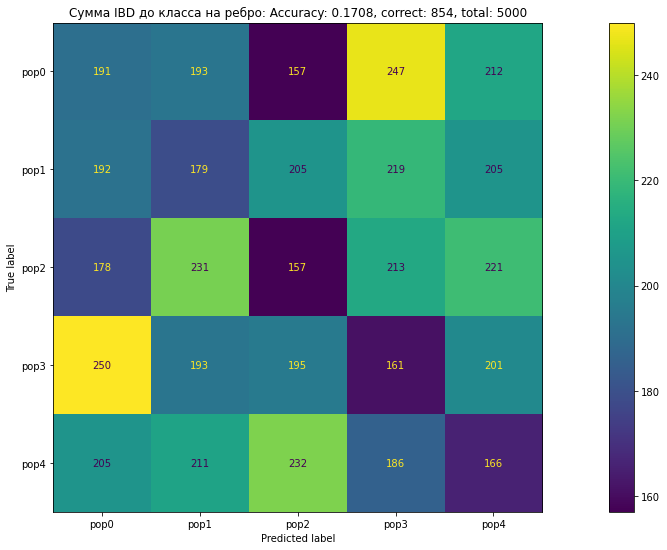

In [23]:
import time
start = time.time()
faketranslation = np.arange(len(G.nodes))
featuredict = bh.getfeatures(G, G.nodes, nodeclasses, labeldict, pairs, faketranslation )
print(f"features collected in {time.time()-start} seconds\n")

simplepredictions = bh.getsimplepred(featuredict)
for feature in featuredict:
    prediction = simplepredictions[feature]
    title = featuredict[feature]["comment"]
    bh.show_prediction(labels, prediction, labeldict.keys(), title)    

In [11]:
for feature in featuredict:
    print(f"{feature}: {featuredict[feature]['comment']}")

SegmentCount: Число ребер до класса
SegmentCountPerClassize: Число ребер до класса на размер класса
SegmentCountWMult: Число ребер до класса с учетом сегментов
LongestIbd: Самый длинный сегмент
IbdSum: Сумма IBD до класса
IbdSumPerEdge: Сумма IBD до класса на ребро


# Вариант классификации для большего сходства с оценкой метрик для графовых нейросетей

1. Выделим 30% тестовых вершин, остальные считаем тренировочными
2. Для каждой тестовой вершины суммируем фичи по классам только до тренировочных вершин

train|test distribution
pop0 : 700 : 300
pop1 : 700 : 300
pop2 : 700 : 300
pop3 : 700 : 300
pop4 : 700 : 300
train nodes: 3500
test nodes: 1500
Число ребер до класса: Accuracy: 0.9227, correct: 1384, total: 1500
              precision    recall  f1-score   support

        pop0       0.99      1.00      1.00       300
        pop1       0.84      0.95      0.89       300
        pop2       0.96      0.90      0.93       300
        pop3       0.94      0.79      0.86       300
        pop4       0.90      0.97      0.93       300

    accuracy                           0.92      1500
   macro avg       0.93      0.92      0.92      1500
weighted avg       0.93      0.92      0.92      1500



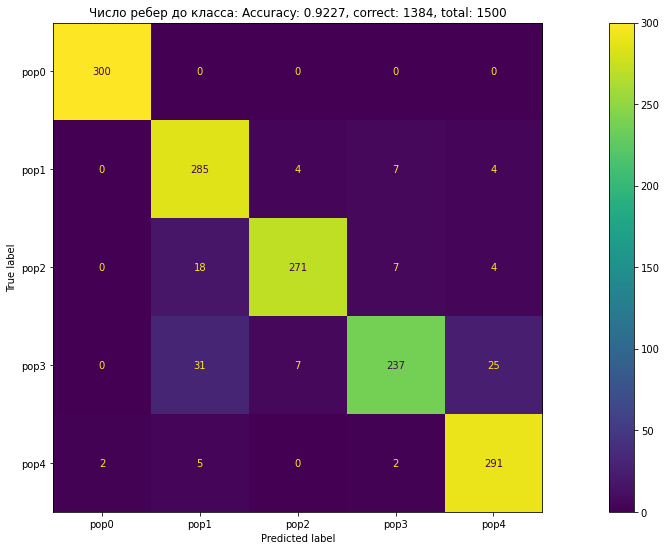

In [12]:
testshare = 0.3
trainnodeclasses, testnodeclasses = bh.dividetraintest(nodeclasses, testshare)

print("train|test distribution")
for c in trainnodeclasses:
    print(c, ":", trainnodeclasses[c].shape[0], ":", testnodeclasses[c].shape[0])

trainnodes, testnodes = bh.gettraintestnodes(trainnodeclasses, testnodeclasses)
print("train nodes:", trainnodes.shape[0])
print("test nodes:", testnodes.shape[0])

testlabels = np.array([ labels[node] for node in testnodes])

featuredict = bh.getfeatures(G, testnodes, trainnodeclasses, pairs, labeldict )
predictions = bh.getsimplepred(featuredict)

predictedlabels = np.array([ predictions["SegmentCount"][node] for node in testnodes])

title = featuredict["SegmentCount"]["comment"]
bh.show_prediction(testlabels, predictedlabels, labeldict.keys(), title)